In [1]:
import import_ipynb
from State_simulation_Final import State

import numpy as np
import matplotlib.pyplot as plt

from scipy.special import comb
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy.interpolate import RegularGridInterpolator, interp1d
from scipy.stats import norm

import qinfer
from qinfer import FiniteOutcomeModel
from qinfer import Distribution
from qinfer import SMCUpdater, UniformDistribution

from copy import deepcopy
import scipy.linalg as la

from qutip import basis, fock, tensor
from qutip import rx, ry, rz, sigmax, sigmay, sigmaz, rotation
from qutip import destroy, create, num, cnot, qeye
from qutip import expect, thermal_dm, ket2dm
from qutip import Qobj, QobjEvo, sesolve

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from State_simulation_Final.ipynb


# 

# 

# 

In [2]:
def plot(updater, i, mu, sig, optimal_setting, modelparams):
    
    # Just a plotting function to better visualize the optimization data
    
    plt.figure(figsize=(5, 12), dpi=150)
    
    ax = plt.subplot(411)
    ax.hist(updater.particle_locations[:,0], weights=updater.particle_weights)
    ax.set_xlabel('Rabi')
    
    ax = plt.subplot(412)
    steps=np.arange(i+1)
    ax.scatter(steps[:-1], optimal_setting)

    plt.xlabel('step')
    plt.ylabel('# of gates')

    ax = plt.subplot(413)

    plt.plot(steps, mu[:,0])
    plt.legend(['$\mu_\Omega$'])
    plt.xscale('log')
    plt.grid()

    ax = plt.subplot(414)
    
    plt.plot(steps, sig[:,0]*np.sqrt(2/np.pi))
    plt.plot(steps, np.abs(mu[:,0]-modelparams[0]))
    #plt.hlines(2/(np.pi*np.sqrt(n_shots_per_meas)*np.max(optimal_setting)),0,i,colors='black', linestyles='dashed')
    #plt.hlines(1/(np.pi*np.sqrt(n_shots_per_meas)*np.max(optimal_setting)),0,i,colors='red', linestyles='dashed')
    plt.legend(['$\sigma_\Omega$', '$|\mu_\Omega-\mu_{opt}|$'])
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()

In [3]:
class LSModel(FiniteOutcomeModel):
    
    @property
    def n_modelparams(self):
        # The model parameters (number of things the qubit population depends over, 
        # in this case, the drive power, SPAM and depolarizing factors)
        return 3
    
    @property
    def is_n_outcomes_constant(self):
        return True
    def n_outcomes(self, expparams):
        return 3 #gg, ee, eg+ge
    
    def are_models_valid(self, modelparams):
        
        return np.logical_and(modelparams[:,0] > 0.2, modelparams[:,0] < np.sqrt(2))
    
        # The last two just correspond to the limits of the interpolation range
        # The first one just assumes that we know that our laser power is not too low (so greater than 0.2)
        # and has to be limited above by 1.4 so that the likelihood for a single LS gate
        # in the first step is a monotonic function, that is, it will not create a multimodal
        # particle distribution already in step 2.


    @property
    def expparams_dtype(self):
        return [('n_gates', 'int')]

    def likelihood(self, outcomes, modelparams, expparams):
        
        # Computes the likelihood of an outcome given a modelparam and an expparam (# of gates)
        
        super(LSModel, self).likelihood(
            outcomes, modelparams, expparams)
        
        expparams=np.squeeze(expparams)
        try:
            probabilities = np.array([(1/2*(1-np.cos(modelparams[:,0]**2*np.pi*expparams/2))*
                             (2*modelparams[:,1]-1)**2+1/4*np.sin(np.pi*modelparams[:,1])**1.7-1/4)*(1-modelparams[:,2])**expparams+1/4,
                             (1/2*(1+np.cos(modelparams[:,0]**2*np.pi*expparams/2))*
                             (2*modelparams[:,1]-1)**2+1/4*np.sin(np.pi*modelparams[:,1])**1.7-1/4)*(1-modelparams[:,2])**expparams+1/4,
                             0.5-((2*modelparams[:,1]-1)**2+0.5*np.sin(np.pi*modelparams[:,1])**1.7-0.5)*(1-modelparams[:,2])**expparams])
        except:
            print(modelparams[:,0]**2*np.pi*expparams/2)
        probabilities=probabilities.reshape(3, -1, 1).real
        
        
        # Computes the likelihood

        if len(np.shape(outcomes)) == 0:
            outcomes = np.array(outcomes)[None];
                    
        likelihood_array= np.concatenate([
            probabilities[np.newaxis, outcomes[idx]]
            for idx in range(outcomes.shape[0])
        ])
        # Generates the likelihood array for every outcome that you want to measure

        return likelihood_array

    
def variance(positions, weights): # Usual variance formula
    
    mean = np.dot(weights, positions)
    return np.dot(weights, (positions-mean)**2)

def expected_variance_decrease(updater, expparams):
        
        os = np.arange(3) # the possible outcomes, gg, ee, and eg/ge

        w_hyp, L, N = updater.hypothetical_update(
                os[:-1], 
                expparams, 
                return_normalization=True, 
                return_likelihood=True
            )
        
        # calculates the weights of the particles for each outcome
        
        w_hyp_last_outcome = (1 - L.sum(axis=0)) * updater.particle_weights[np.newaxis, :]
        N = np.concatenate([N[:,:,0], np.sum(w_hyp_last_outcome[np.newaxis,:,:], axis=2)], axis=0)
        w_hyp_last_outcome = w_hyp_last_outcome / N[-1,:,np.newaxis]
        w_hyp = np.concatenate([w_hyp, w_hyp_last_outcome[np.newaxis,:,:]], axis=0)

        
        sig_exp = sum(variance(updater.particle_locations, w_hyp[i,0])*N[i] for i in os)
        # calculates the expected variance after this measurement
        
        sig = variance(updater.particle_locations, updater.particle_weights)
        # the current variance of the particle distribution
        
        return (sig-sig_exp)[0]


def power2rabi(x, logpower):
    
    if logpower:
        
        # We don't now the precise relation between laser power and Rabi frequency, so here
        # we define some function that could be some power-to-Rabi relation. We choose to work here
        # with this log function because it seems to be qualitatively similar to the behavior of the power-to-Rabi
        # relation in the actual quantum computer.
        # The only requirement for this function is that at power=optimal power, Rabi=1
        
        #return np.array([[np.log2(x[0]+1), x[1], x[2]]])
        return np.array([[np.arctan(2*x[0])/np.arctan(2), x[1], x[2]]])
    else:
        return np.array([[x[0], x[1], x[2]]])
    
def measurement_loop(n_meas, n_shots_per_meas, model, updater, meas_settings, modelparams, 
                     thresh=None, plot_distributions=None, logpower=None):
    """
    
    This program takes an updater with a particle distribution that follows a uniform distribution over a
    specified range. At every step in range(n_meas) (or until it stops), it finds what is the best meas setting
    to use (how many gates to apply), simulates a measurement with that setting and with the "actual" rabi
    frequency, and with the outcome of that simulated measurement updates the position of the particles,
    reducing the variance of the distribution.
    
    
    :model: where we specify the outcomes, their likelihoods, their parameters, etc. (see LSModel above)
    :updater: the object that contains information about the particle locations and weights
    :meas_settings: whether we apply 1,3,5,7 gates, represented by an array [0,1,2,3]
    :modelparams: the "actual" values we want to obtain, for simulation purposes only, a list with a single value
    :n_meas, n_shots_per_meas: int's
    :thresh: float, the value of the particle distribution variance at which we stop the Bayesian update
    :plot_distributions: bool, in case you want to see the particle distribution and measurement outcomes at each step
    :logpower: bool, in case you want to use some power-to-Rabi relation that is not the trivial one (Rabi=power)
    
    
    """
    particle_locations=np.zeros((n_meas, 1000))
    particle_weights=np.zeros((n_meas, 1000))

    optimal_setting = np.zeros(n_meas)
    ydata = np.zeros((n_meas,n_shots_per_meas))
    mu = np.zeros((n_meas+1, model.n_modelparams))
    sig = np.zeros((n_meas+1, model.n_modelparams))
    
    mu[0] = updater.est_mean()
    sig[0] = variance(updater.particle_locations, updater.particle_weights)
    
    init=1
    
    for i in tqdm(range(n_meas)):
        info_gain = [expected_variance_decrease(updater, np.array([meas_settings[i]+init])) 
                     for i in range(len(meas_settings))]

        opt_meas_set = np.array([meas_settings[np.argmax(info_gain)]+init]) 
        # Chooses the one that will minimize the variance the most
        init=opt_meas_set[0]
        datum = np.squeeze(model.simulate_experiment(power2rabi(modelparams, logpower),
                                                     opt_meas_set, repeat=n_shots_per_meas))
        # Simulates an experiment with the Rabi frequency given by the conversion, which the 
        # likelihood function doesn't "know"
        
        
        if plot_distributions:
            fig, ax = plt.subplots()
            ax.hist(updater.particle_locations[:,0]*mu[i,0]/mu[0,0], weights=updater.particle_weights)
            print(np.unique(datum, return_counts=True))
        
        for d in datum:
            updater.update(d, opt_meas_set)
            # updates the weights of the particles

        ydata[i] = datum
        optimal_setting[i] = opt_meas_set[0]

        mu[i+1,0] = mu[i,0]*updater.est_mean()[0]
        mu[i+1,1] = updater.est_mean()[1]
        
        sig[i+1] = variance(updater.particle_locations, updater.particle_weights)
        
        modelparams[0]/=updater.est_mean()[0]
        # updates the power of the next measurement, assuming that the relation between
        # Rabi and power is linear (because the optimizer doesn't "know" the power-to-Rabi relation)
        
        updater.particle_locations[:,0]/=updater.est_mean()[0]
        # updates the particle distribution, bringing the average to 0
        
        
        if thresh!=None:
            if np.all(np.sqrt(sig[i+1])<thresh):
                break # stops updating when variance reaches threshold
    
    mu[:,0]/=mu[0,0]
    updater.particle_locations[:,0]*=mu[i+1,0]

    ydata = 1-ydata.mean(axis=1)
    
    i+=1
    
    mu = mu[:i+1]
    sig = sig[:i+1]
    optimal_setting = optimal_setting[:i]
    ydata = ydata[:i+1]
    particle_locations=particle_locations[:i+1]
    particle_weights=particle_weights[:i+1]
    
    
    return updater, i, mu, sig, optimal_setting, ydata, modelparams

  0%|          | 0/1000 [00:00<?, ?it/s]

2.7524566424077133


<IPython.core.display.Javascript object>


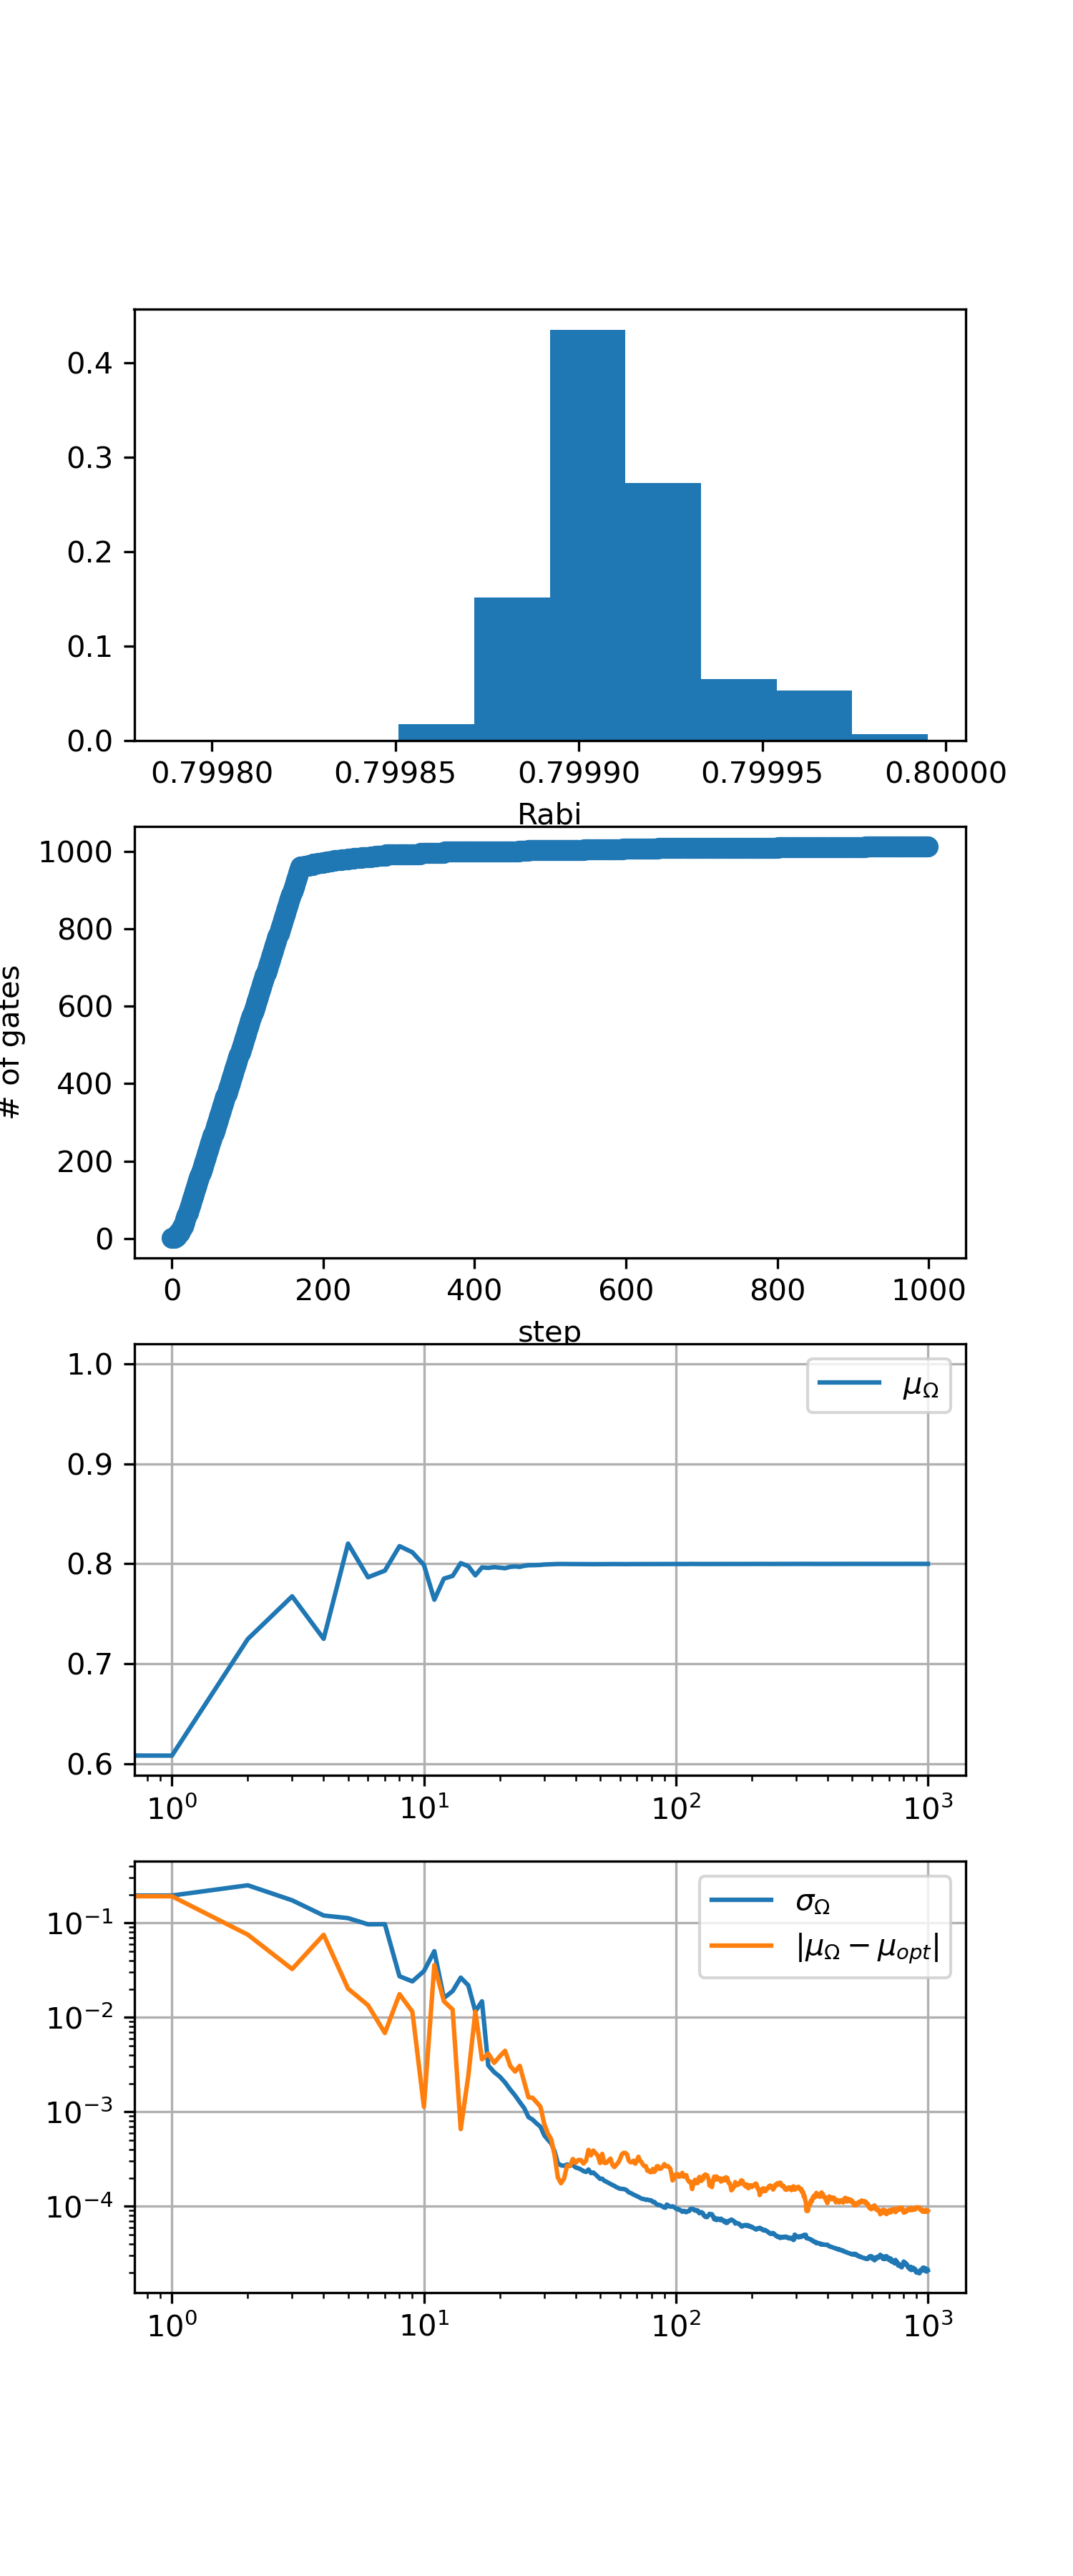

Finished in 1000 steps with value power=0.7999\pm0.0000, SPAM=0.2000\pm0.0000


In [449]:
model = LSModel()
modelparams = np.array([0.8, 0.003, 0.002]) # The values at which the measurement outcomes will be generated
params_0=np.copy(modelparams)
dep=0.001
prior = UniformDistribution([[.2, np.sqrt(2)], [0.2, 0.2], [dep, dep]])
# We can start with a smaller range for the prior of the Rabi frequency, depending on 
# our current knowledge of possible laser powers.

# Notice that the range for the SPAM and depolarizing values here is 0. This is because
# we don't want the optimizer to learn them, as in the real experiment. We can see that
# the optimization works even if the SPAM and depolarizing values that the optimizer assumes
# is different from the values at which the measurement data is generated

updater = SMCUpdater(model, 100, prior)
# Creates an updater with 1000 particles

meas_settings = np.array([0, 2, 4, 6]) # 0, 1, 2, 3 corresponds to 1, 3, 5, 7 gates respectively

n_meas = 1000

n_shots_per_meas = 5

thresh=0.0

updater, i, mu, sig, optimal_setting, ydata, params = measurement_loop(
    n_meas, n_shots_per_meas, model, deepcopy(updater),
    meas_settings, modelparams, thresh, plot_distributions=False, logpower=True)

print((1+dep)**np.max(optimal_setting))
plot(updater, i, mu, np.sqrt(sig), optimal_setting, params_0)

print("Finished in {} steps with value power={:.4f}\pm{:.4f}, SPAM={:.4f}\pm{:.4f}".format(
    i, mu[-1,0], sig[-1,0]/mu[-1,0]*params[0], mu[-1,1], sig[-1,1]))

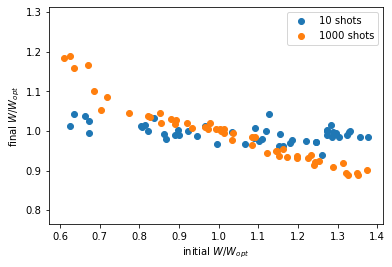

In [198]:
plt.scatter(vals25[:,0], vals25[:,1]/vals25[:,0], label='10 shots')
plt.scatter(vals250[:,0], vals250[:,1]/vals250[:,0], label='1000 shots')
plt.axis('equal')
plt.legend()
plt.xlabel('initial $W/W_{opt}$')
plt.ylabel('final $W/W_{opt}$')
plt.savefig('shots_correlation')

In [195]:
vals25[34,1]=vals25[34,0]

(0.5947268656614976,
 1.4357975343983063,
 0.8971312020936806,
 1.1915075750034732)

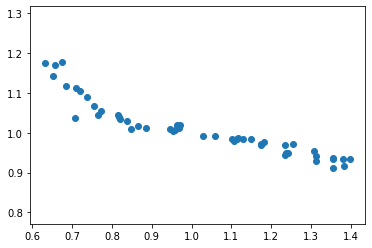

In [178]:
plt.scatter(vals[:,0], vals[:,1]/vals[:,0])
plt.axis('equal')

  0%|          | 0/10000 [00:00<?, ?it/s]

Finished in 10000 steps with value power=1.2976\pm0.0000, SPAM=0.0100\pm0.0000


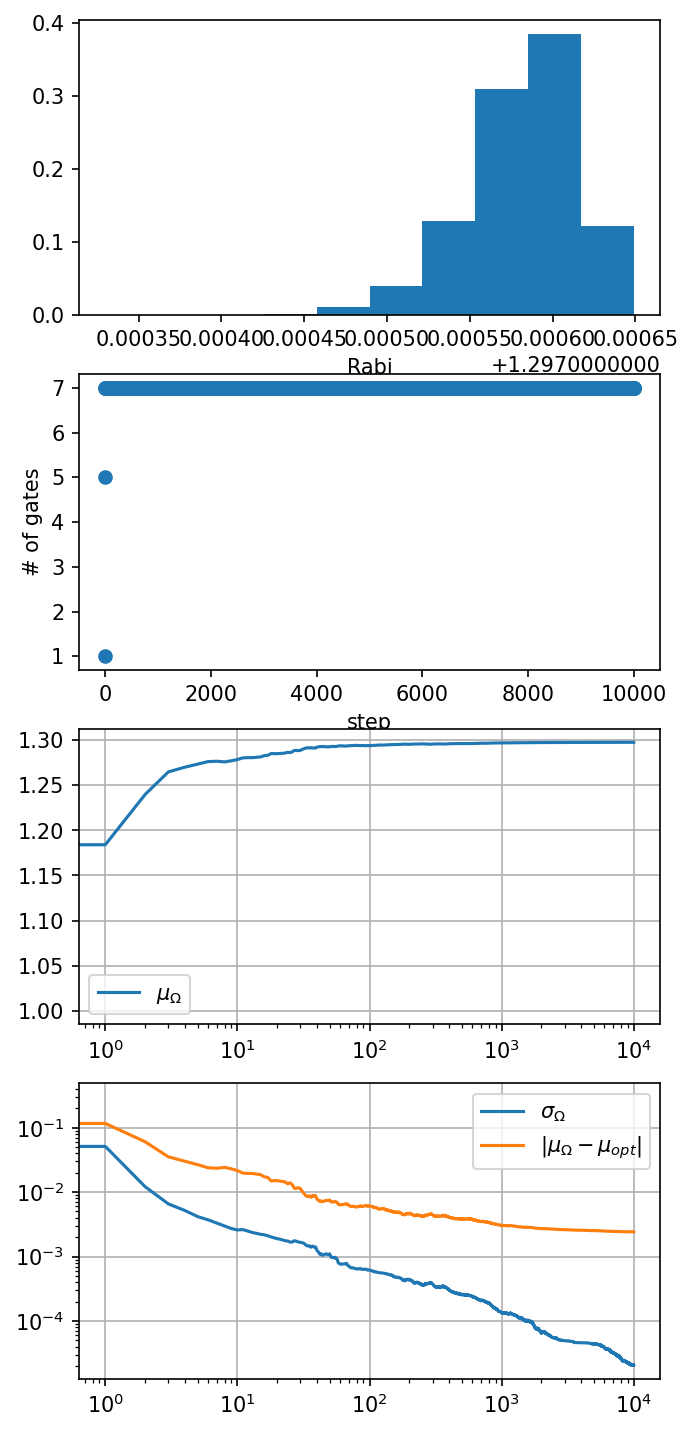

In [14]:
model = LSModel()
modelparams = np.array([1.3, 0.017, 0.0045]) # The values at which the measurement outcomes will be generated
params_0=np.copy(modelparams)

prior = UniformDistribution([[.2, 1.4], [0.01, 0.01], [0.0025, 0.0025]])
# We can start with a smaller range for the prior of the Rabi frequency, depending on 
# our current knowledge of possible laser powers.

# Notice that the range for the SPAM and depolarizing values here is 0. This is because
# we don't want the optimizer to learn them, as in the real experiment. We can see that
# the optimization works even if the SPAM and depolarizing values that the optimizer assumes
# is different from the values at which the measurement data is generated

updater = SMCUpdater(model, 1000, prior)
# Creates an updater with 1000 particles

meas_settings = np.arange(4).astype(int) # 0, 1, 2, 3 corresponds to 1, 3, 5, 7 gates respectively

n_meas = 10000

n_shots_per_meas = 25

thresh=0.0

updater, i, mu, sig, optimal_setting, ydata, params = measurement_loop(
    n_meas, n_shots_per_meas, model, deepcopy(updater),
    meas_settings, modelparams, thresh, plot_distributions=False, logpower=True)

plot(updater, i, mu, np.sqrt(sig), optimal_setting, params_0)

print("Finished in {} steps with value power={:.4f}\pm{:.4f}, SPAM={:.4f}\pm{:.4f}".format(
    i, mu[-1,0], sig[-1,0]/mu[-1,0]*params[0], mu[-1,1], sig[-1,1]))

  0%|          | 0/10000 [00:00<?, ?it/s]

Finished in 10000 steps with value power=1.2998\pm0.0000, SPAM=0.0100\pm0.0000


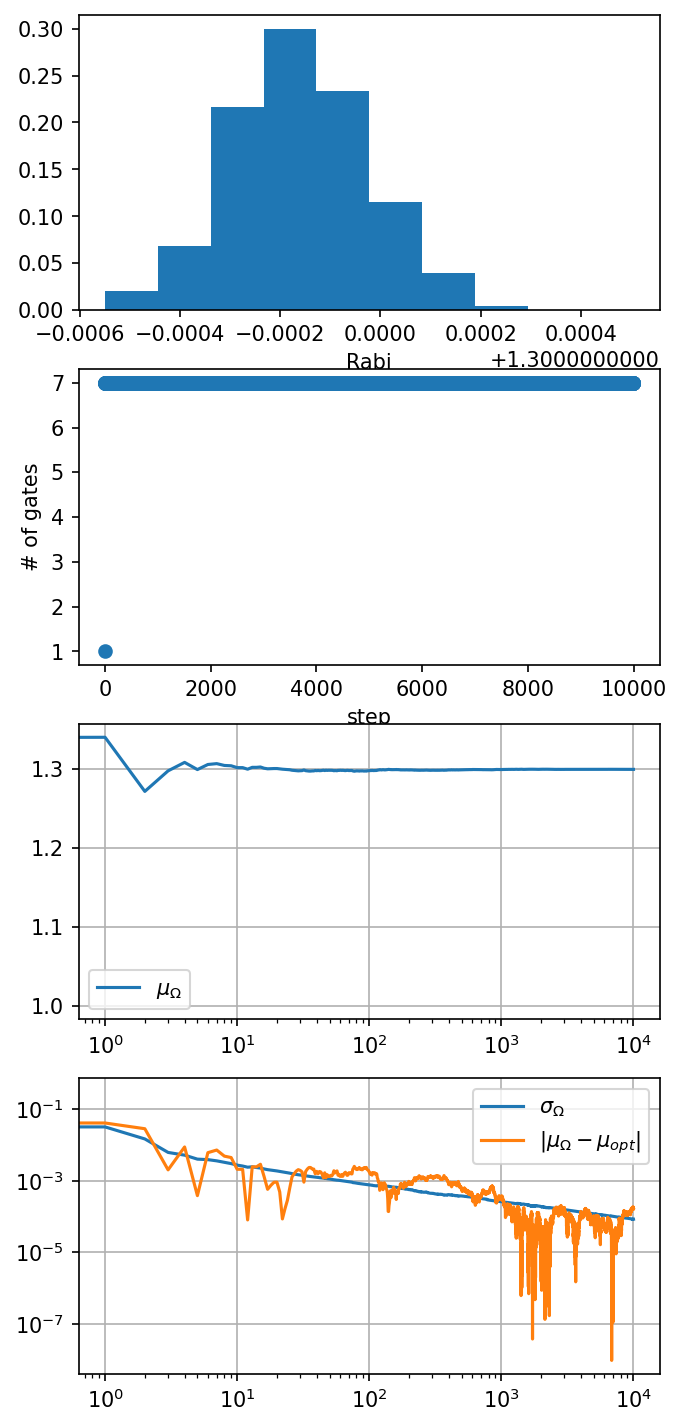

In [16]:
model = LSModel()
modelparams = np.array([1.3, 0.017, 0.0045]) # The values at which the measurement outcomes will be generated
params_0=np.copy(modelparams)

prior = UniformDistribution([[.2, 1.4], [0.01, 0.01], [0.0025, 0.0025]])
# We can start with a smaller range for the prior of the Rabi frequency, depending on 
# our current knowledge of possible laser powers.

# Notice that the range for the SPAM and depolarizing values here is 0. This is because
# we don't want the optimizer to learn them, as in the real experiment. We can see that
# the optimization works even if the SPAM and depolarizing values that the optimizer assumes
# is different from the values at which the measurement data is generated

updater = SMCUpdater(model, 1000, prior)
# Creates an updater with 1000 particles

meas_settings = np.arange(4).astype(int) # 0, 1, 2, 3 corresponds to 1, 3, 5, 7 gates respectively

n_meas = 10000

n_shots_per_meas = 25

thresh=0.0

updater, i, mu, sig, optimal_setting, ydata, params = measurement_loop(
    n_meas, n_shots_per_meas, model, deepcopy(updater),
    meas_settings, modelparams, thresh, plot_distributions=False, logpower=True)

plot(updater, i, mu, np.sqrt(sig), optimal_setting, params_0)

print("Finished in {} steps with value power={:.4f}\pm{:.4f}, SPAM={:.4f}\pm{:.4f}".format(
    i, mu[-1,0], sig[-1,0]/mu[-1,0]*params[0], mu[-1,1], sig[-1,1]))

  0%|          | 0/10000 [00:00<?, ?it/s]

Finished in 10000 steps with value power=0.4001\pm0.0000, SPAM=0.0100\pm0.0000


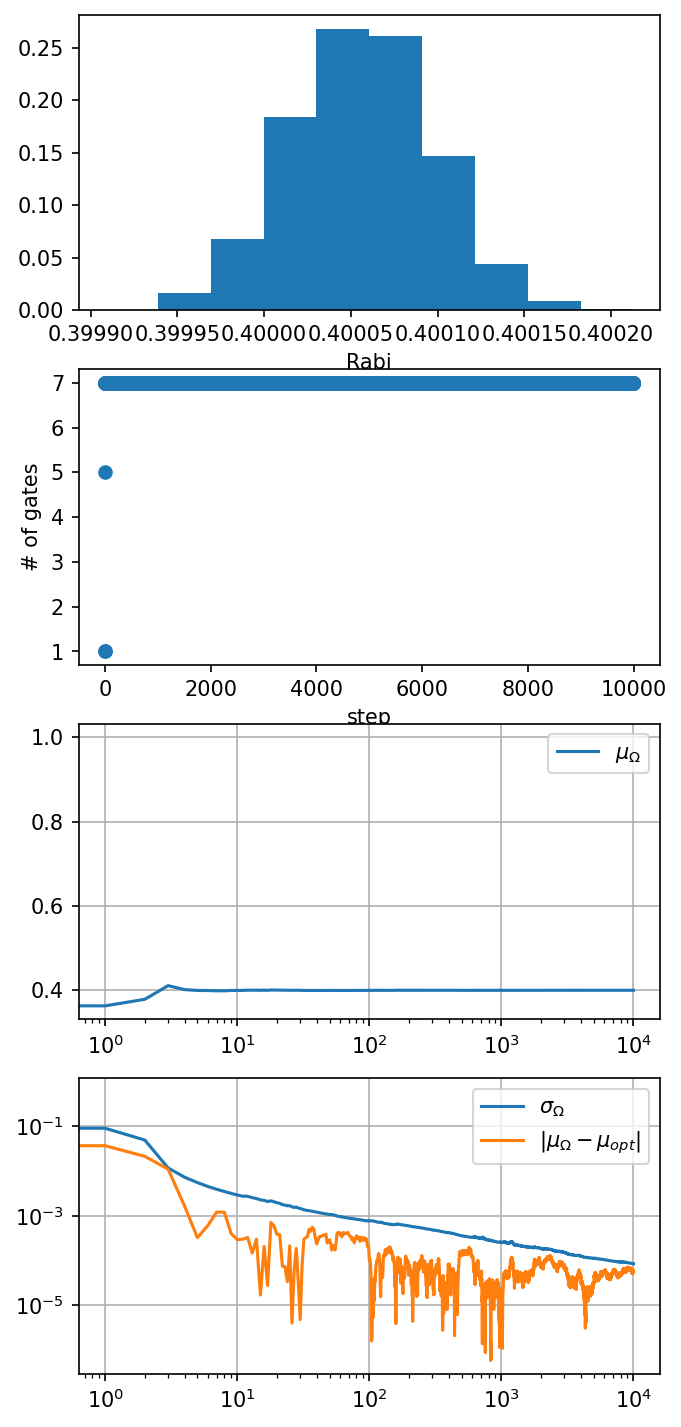

In [18]:
model = LSModel()
modelparams = np.array([0.4, 0.017, 0.0045]) # The values at which the measurement outcomes will be generated
params_0=np.copy(modelparams)

prior = UniformDistribution([[.2, 1.4], [0.01, 0.01], [0.0025, 0.0025]])
# We can start with a smaller range for the prior of the Rabi frequency, depending on 
# our current knowledge of possible laser powers.

# Notice that the range for the SPAM and depolarizing values here is 0. This is because
# we don't want the optimizer to learn them, as in the real experiment. We can see that
# the optimization works even if the SPAM and depolarizing values that the optimizer assumes
# is different from the values at which the measurement data is generated

updater = SMCUpdater(model, 1000, prior)
# Creates an updater with 1000 particles

meas_settings = np.arange(4).astype(int) # 0, 1, 2, 3 corresponds to 1, 3, 5, 7 gates respectively

n_meas = 10000

n_shots_per_meas = 25

thresh=0.0

updater, i, mu, sig, optimal_setting, ydata, params = measurement_loop(
    n_meas, n_shots_per_meas, model, deepcopy(updater),
    meas_settings, modelparams, thresh, plot_distributions=False, logpower=True)

plot(updater, i, mu, np.sqrt(sig), optimal_setting, params_0)

print("Finished in {} steps with value power={:.4f}\pm{:.4f}, SPAM={:.4f}\pm{:.4f}".format(
    i, mu[-1,0], sig[-1,0]/mu[-1,0]*params[0], mu[-1,1], sig[-1,1]))

  0%|          | 0/100 [00:00<?, ?it/s]

Finished in 100 steps with value power=1.3000\pm0.0000, SPAM=0.0100\pm0.0000


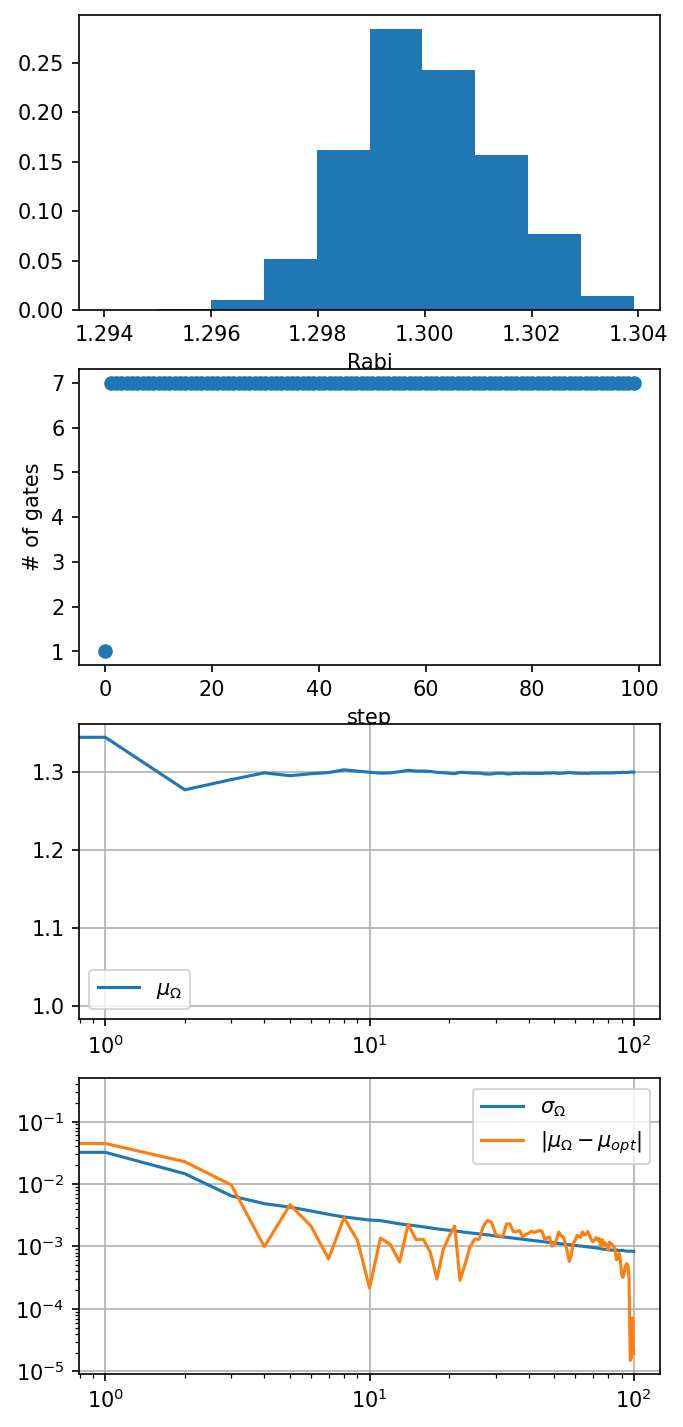

In [20]:
model = LSModel()
modelparams = np.array([1.3, 0.017, 0.0045]) # The values at which the measurement outcomes will be generated
params_0=np.copy(modelparams)

prior = UniformDistribution([[.2, 1.4], [0.01, 0.01], [0.0025, 0.0025]])
# We can start with a smaller range for the prior of the Rabi frequency, depending on 
# our current knowledge of possible laser powers.

# Notice that the range for the SPAM and depolarizing values here is 0. This is because
# we don't want the optimizer to learn them, as in the real experiment. We can see that
# the optimization works even if the SPAM and depolarizing values that the optimizer assumes
# is different from the values at which the measurement data is generated

updater = SMCUpdater(model, 1000, prior)
# Creates an updater with 1000 particles

meas_settings = np.arange(4).astype(int) # 0, 1, 2, 3 corresponds to 1, 3, 5, 7 gates respectively

n_meas = 100

n_shots_per_meas = 25

thresh=0.0

updater, i, mu, sig, optimal_setting, ydata, params = measurement_loop(
    n_meas, n_shots_per_meas, model, deepcopy(updater),
    meas_settings, modelparams, thresh, plot_distributions=False, logpower=True)

plot(updater, i, mu, np.sqrt(sig), optimal_setting, params_0)

print("Finished in {} steps with value power={:.4f}\pm{:.4f}, SPAM={:.4f}\pm{:.4f}".format(
    i, mu[-1,0], sig[-1,0]/mu[-1,0]*params[0], mu[-1,1], sig[-1,1]))